In [ ]:
!pip install flask tensorflow deepxde numpy matplotlib





In [ ]:
!python --version



In [ ]:
import flask
import deepxde
import tensorflow
import numpy
import matplotlib

print("All dependencies installed successfully!")



In [21]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Constants
E = 200e9  # Young's modulus (Pa)
P = 1000   # Applied force (N)
L = 1.0    # Length of the bar (m)

# For better convergence, modify the PDE definition:
def pde(x, u):
    du_dx = dde.grad.jacobian(u, x)
    d2u_dx2 = dde.grad.hessian(u, x)
    return E * d2u_dx2  # Should equal zero for equilibrium


# Boundary Conditions
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Problem Definition
geom = dde.geometry.Interval(0, L)
bc_left = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left)
bc_right = dde.icbc.OperatorBC(geom, 
    lambda x, u, _: E*dde.grad.jacobian(u, x) - P,
    boundary_right)

data = dde.data.PDE(
    geom,
    pde,
    [bc_left, bc_right],
    num_domain=50,
    num_boundary=10,
    solution=None,
    num_test=100
)

# Neural Network
net = dde.maps.FNN([1] + [40] * 4 + [1], "tanh", "Glorot normal")



model = dde.Model(data, net)



# In the model.compile() line, remove the metrics parameter:
model.compile("adam", lr=0.001)  # Remove metrics=["l2 relative error"]

# Modified training configuration section:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)  # Corrected line
losshistory, train_state = model.train(epochs=10000, display_every=1000)

# Post-processing
x_test = np.linspace(0, L, 100).reshape(-1, 1)
u_pred = model.predict(x_test)

x_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
u_tensor = model.predict(x_test)


if u_tensor is None:
    raise ValueError("model.predict(x_test) returned None. Check if the model is trained properly.")

u_tensor = tf.convert_to_tensor(u_tensor, dtype=tf.float32)

# Correct gradient calculation using TensorFlow backend
# For full model evaluation (including transforms)
with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    u_tensor = model.predict(x_tensor)
    
du_dx_pred = tape.gradient(u_tensor, x_tensor).numpy()






du_dx_pred = tape.gradient(u_tensor, x_tensor).numpy()
d2u_dx2_pred = tape.gradient(du_dx_pred, x_tensor).numpy()
stress_pred = E * du_dx_pred

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(x_test, u_pred, 'b-')
plt.title("Displacement")
plt.xlabel("x (m)")
plt.ylabel("u(x) (m)")

plt.subplot(1, 3, 2)
plt.plot(x_test, du_dx_pred, 'g-')
plt.title("Strain")
plt.xlabel("x (m)")
plt.ylabel("ε(x)")

plt.subplot(1, 3, 3)
plt.plot(x_test, stress_pred/1e6, 'r-')
plt.title("Stress")
plt.xlabel("x (m)")
plt.ylabel("σ(x) (MPa)")


plt.tight_layout()
plt.show()



Compiling model...
Building feed-forward neural network...
'build' took 0.029648 s

'compile' took 0.291199 s

Compiling model...
'compile' took 0.605267 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.20e+21, 0.00e+00, 2.39e+21]    [2.45e+21, 0.00e+00, 2.39e+21]    []  
1000      [nan, nan, nan]                   [nan, nan, nan]                   []  

Best model at step 0:
  train loss: 4.60e+21
  test loss: 4.85e+21
  test metric: []

'train' took 1.686765 s



NotImplementedError: Cannot convert a symbolic tf.Tensor (Const_240:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

# Perplexity 


In [22]:
import torch
import numpy as np

# Define neural network architecture
class StressStrainNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 50),  # Input: spatial coordinate (x)
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)   # Output: displacement (u)
        )
        
    def forward(self, x):
        return self.layers(x)



In [38]:
def physics_loss(model, x, E, body_force):
    # DELETED LINE - x.requires_grad = True (caused error)
    u = model(x)
    
    du_dx = torch.autograd.grad(u, x, 
              grad_outputs=torch.ones_like(u),
              create_graph=True, 
              retain_graph=True)[0]  # Keep gradients
    
    epsilon = du_dx  # Strain
    sigma = E * epsilon  # Stress
    
    # Equilibrium residual
    dsigma_dx = torch.autograd.grad(sigma, x, 
    
                 grad_outputs=torch.ones_like(sigma),
                 create_graph=True)[0]
    
    residual = dsigma_dx + body_force
    return torch.mean(residual**2)


In [42]:
def boundary_loss(model, L, E, F, A):
    # Fixed displacement boundary (u=0 at x=0)
    x0 = torch.zeros(1, requires_grad=True)
    u0_pred = model(x0)
    bc_loss = u0_pred**2
    
    # Traction boundary (σ=F/A at x=L)
    xL = torch.full((1,1), L, requires_grad=True)
    uL_pred = model(xL)
    du_dx = torch.autograd.grad(uL_pred, xL, 
              grad_outputs=torch.ones_like(uL_pred),
              create_graph=True)[0]
    sigma_pred = E * du_dx
    traction_loss = (sigma_pred - F/A)**2
    
    return bc_loss + traction_loss



In [51]:
# Normalize parameters
E = E / 1e9  # Scale Young's modulus to GPa
F = F / 1e3  # Scale force to kN
A = A        # Keep area as is

# Normalize x (spatial points)
x = torch.rand(100, 1, requires_grad=True) * 1.0  # Already normalized (0 to 1)



In [52]:
import time

# Initialize model and optimizer
model = StressStrainNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Start training
start_time = time.time()
for epoch in range(10000):
    optimizer.zero_grad()
    
    # Collocation points
    x = torch.rand(100, 1, requires_grad=True) * L
    
    # Compute losses
    loss_physics = physics_loss(model, x, E, body_force=0)
    loss_bc = boundary_loss(model, L, E, F, A)  # Pass all parameters
    total_loss = loss_physics + loss_bc
    
    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()
    
    # Print losses at regular intervals
    if epoch % 1000 == 0 or epoch == 9999:
        elapsed_time = time.time() - start_time
        print(f"Epoch: {epoch}, Total Loss: {total_loss.item():.6f}, "
              f"Physics Loss: {loss_physics.item():.6f}, "
              f"Boundary Loss: {loss_bc.item():.6f}, "
              f"Elapsed Time: {elapsed_time:.2f} seconds")



Epoch: 0, Total Loss: 21415.728516, Physics Loss: 244.081680, Boundary Loss: 21171.646484, Elapsed Time: 0.00 seconds
Epoch: 1000, Total Loss: 0.912996, Physics Loss: 0.909436, Boundary Loss: 0.003561, Elapsed Time: 0.84 seconds
Epoch: 2000, Total Loss: 0.137285, Physics Loss: 0.137225, Boundary Loss: 0.000060, Elapsed Time: 1.64 seconds
Epoch: 3000, Total Loss: 0.006209, Physics Loss: 0.006204, Boundary Loss: 0.000006, Elapsed Time: 2.43 seconds
Epoch: 4000, Total Loss: 0.005232, Physics Loss: 0.005231, Boundary Loss: 0.000001, Elapsed Time: 3.22 seconds
Epoch: 5000, Total Loss: 0.002065, Physics Loss: 0.001984, Boundary Loss: 0.000081, Elapsed Time: 4.01 seconds
Epoch: 6000, Total Loss: 0.001698, Physics Loss: 0.001666, Boundary Loss: 0.000032, Elapsed Time: 4.80 seconds
Epoch: 7000, Total Loss: 0.002543, Physics Loss: 0.002125, Boundary Loss: 0.000418, Elapsed Time: 5.59 seconds
Epoch: 8000, Total Loss: 0.002711, Physics Loss: 0.002659, Boundary Loss: 0.000052, Elapsed Time: 6.39 se

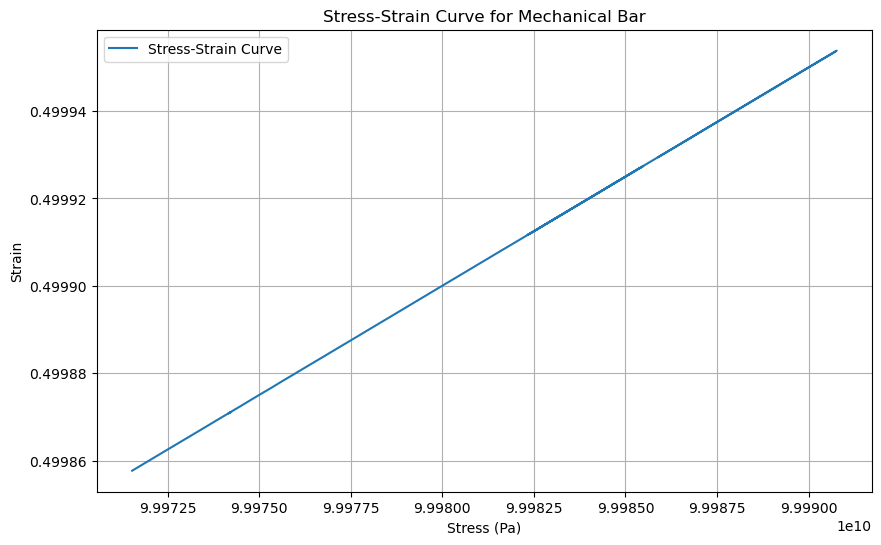

In [53]:
import torch
import matplotlib.pyplot as plt

# Define material and geometric parameters
E = 200e9  # Young's modulus (Pa)
L = 1.0    # Length of the bar (m)
F = 1000.0 # Applied force (N)
A = 0.01   # Cross-sectional area (m^2)

# Generate spatial points along the bar
x = torch.linspace(0, L, 100).view(-1, 1).requires_grad_(True)

# Predict displacement using the trained model
u_pred = model(x)

# Compute strain (du/dx)
du_dx = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

# Compute stress using Hooke's law: σ = E * ε
strain = du_dx.detach().numpy()
stress = (E * strain).flatten()

# Plot stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(stress, strain, label="Stress-Strain Curve")
plt.xlabel("Stress (Pa)")
plt.ylabel("Strain")
plt.title("Stress-Strain Curve for Mechanical Bar")
plt.legend()
plt.grid(True)
plt.show()
